# 0 Background

1000ML Insurance wants recommendation of any kind for their current customer database.

The rest of this notebook will attempt to segment their customer database and to better aid the marketing and customer service team.

In other words, 1000ML Insurance has asked me to..

> "Tell me things"
> - CEO





## 0.1 Import libraries

### 0.1.1 Download 3rd party Libraries

In [2]:
!pip install pymysql

     |████████████████████████████████| 51kB 3.8MB/s 


### 0.1.2 Import 3rd Party Libraries

In [0]:
import pandas as pd
import numpy as np
import itertools

import sqlalchemy as db
import pymysql

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

### 0.1.3 Import google to load CSV

This step is only available if we have saved the Query from database into a CSV file

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## 0.2 Load Data into DataFrame

### 0.2.1 Source: Database

In [0]:
# blanked out so you won't be able to see the credentials 😀

### 0.2.2 Source: Google Drive 

In [5]:
url = f'/content/drive/My Drive/1000 ML/Project 4/df.csv'
df = pd.read_csv(url)
df = df.drop(columns='Unnamed: 0')
df.head()

Customer       State  ...  Vehicle_Class Vehicle_Size
0  BU79786  Washington  ...   Two-Door Car      Medsize
1  QZ44356     Arizona  ...  Four-Door Car      Medsize
2  AI49188      Nevada  ...   Two-Door Car      Medsize
3  WW63253  California  ...            SUV      Medsize
4  HB64268  Washington  ...  Four-Door Car      Medsize

[5 rows x 24 columns]

# 1 Exploratory Data Analysis (EDA)

We will begin with some basic analysis to see what kind of data we have

## 1.1 Column functions

In [5]:
# print all unique values for each column
for column in df.columns:
  print(f'{column}: {df[column].nunique()}')

Customer: 9134
State: 5
Customer_Lifetime_Value: 5674
Response: 2
Coverage: 3
Education: 5
Effective_To_Date: 59
EmploymentStatus: 5
Gender: 2
Income: 5694
Location_Code: 3
Marital_Status: 3
Monthly_Premium_Auto: 202
Months_Since_Last_Claim: 36
Months_Since_Policy_Inception: 100
Number_of_Open_Complaints: 6
Number_of_Policies: 9
Policy_Type: 3
Policy: 9
Renew_Offer_Type: 4
Sales_Channel: 4
Total_Claim_Amount: 5106
Vehicle_Class: 6
Vehicle_Size: 3


### 1.1.1 Value Counts

In [16]:
# print the normalized value counts for all categorical column
cat_var_set = set(df.columns) - num_var_set
for column in cat_var_set:
  print(f'{column}: {df[column].value_counts(normalize=True)}')

Education: Bachelor                0.300854
College                 0.293519
High School or Below    0.287059
Master                  0.081125
Doctor                  0.037443
Name: Education, dtype: float64
Renew_Offer_Type: Offer1    0.410773
Offer2    0.320342
Offer3    0.156777
Offer4    0.112109
Name: Renew_Offer_Type, dtype: float64
Gender: F    0.509963
M    0.490037
Name: Gender, dtype: float64
Coverage: Basic       0.609591
Extended    0.300197
Premium     0.090212
Name: Coverage, dtype: float64
Number_of_Policies: 1    0.355923
2    0.251150
3    0.127874
7    0.047405
9    0.045544
4    0.044778
5    0.044559
8    0.042041
6    0.040727
Name: Number_of_Policies, dtype: float64
Policy_Type: Personal Auto     0.743157
Corporate Auto    0.215459
Special Auto      0.041384
Name: Policy_Type, dtype: float64
Sales_Channel: Agent          0.380666
Branch         0.281038
Call Center    0.193234
Web            0.145062
Name: Sales_Channel, dtype: float64
Marital_Status: Married     

# 2 Data Modelling

Since we are given expiry date for the current year, the first thing 1000ML Insurance should do is renew these contracts before spending resoureces to upsell / cross sell

We will base our plots on Customer_Lifetime_Value, because it makes sense to try to keep valuable customers.

## 2.1 Sort Columns

### 2.1.1 Numerical Variables

In [116]:
# get columns that are relevant with Renewing - based on common sense
num_var_set = set(column for column in df.columns if df[column].nunique() > 10)

# we remove Customer and effective_to_date from numerical values
num_var = num_var_set - set((
    'Customer', 
    'Effective_To_Date'
  ))
num_var = list(num_var)
num_var

['Total_Claim_Amount',
 'Customer_Lifetime_Value',
 'Income',
 'Monthly_Premium_Auto',
 'Months_Since_Policy_Inception',
 'Months_Since_Last_Claim']

### 2.2.2 Categorical Variables

In [117]:
# get important categorical variables
cat_var_set = set(df.columns) - num_var_set

# take out the "Not so important variables"
cat_var = cat_var_set - set((
    'Coverage',
    'Education',
    'EmploymentStatus',
    'Gender',
    'Location_Code',
    'Number_of_Open_Complaints',
    'Number_of_Policies',
    'Policy',
    'Policy_Type',
    'Response',
    'State',
    'Vehicle_Class'
))

cat_var

{'MVP', 'Marital_Status', 'Renew_Offer_Type', 'Sales_Channel', 'Vehicle_Size'}

## 2.2 Pair Plot of `num_var` by `cat_var`

We plot all numerical variables with categorical labels to see if we find any pattern

### 2.2.1 Marital Status

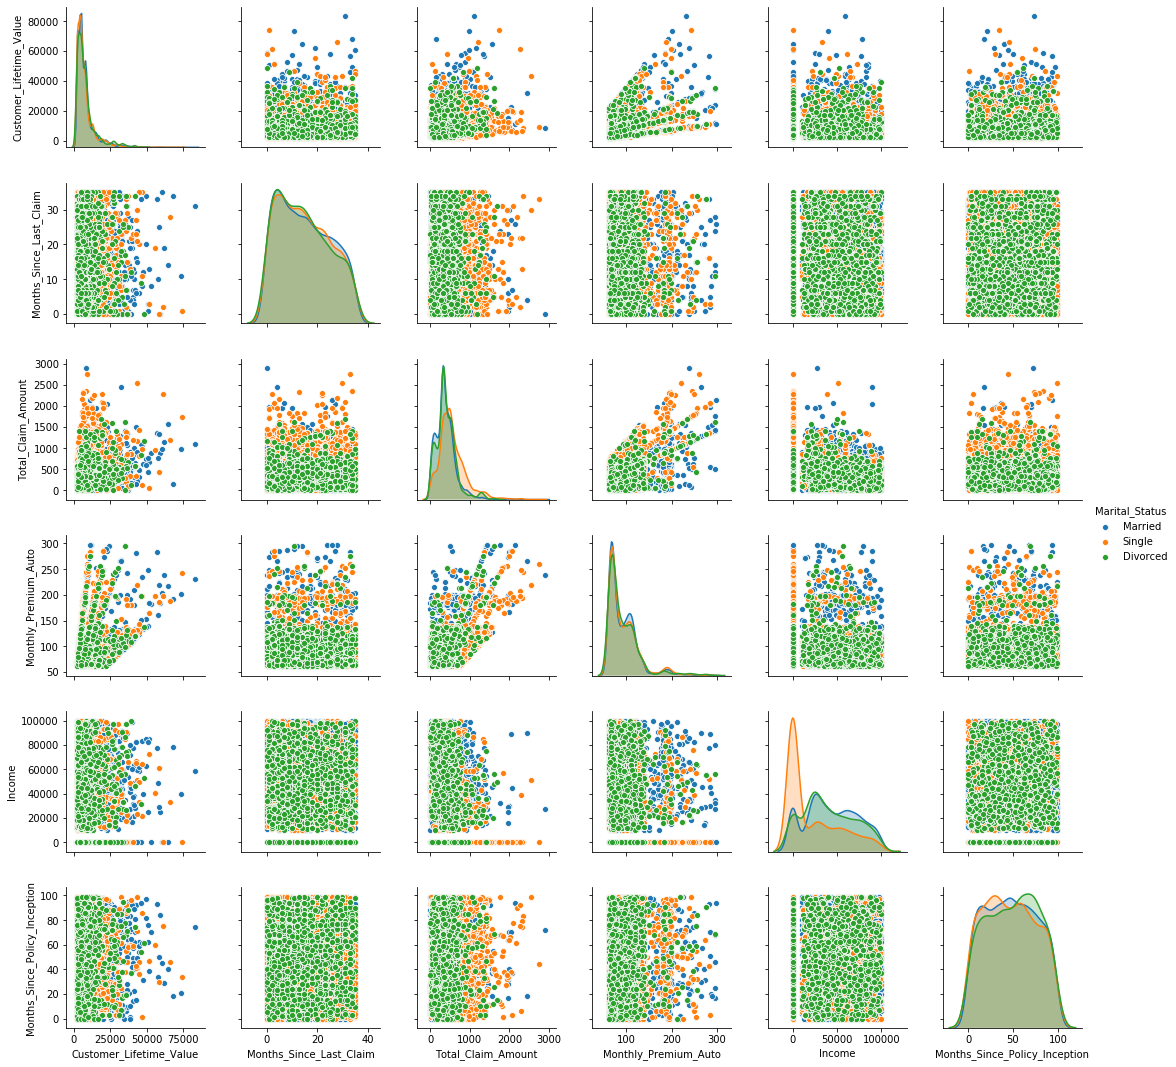

In [28]:
# we cannot pair plot with axes :(
sns.pairplot(df, hue='Marital_Status', vars=num_var)

### 2.2.2 Renew_Offer_Type

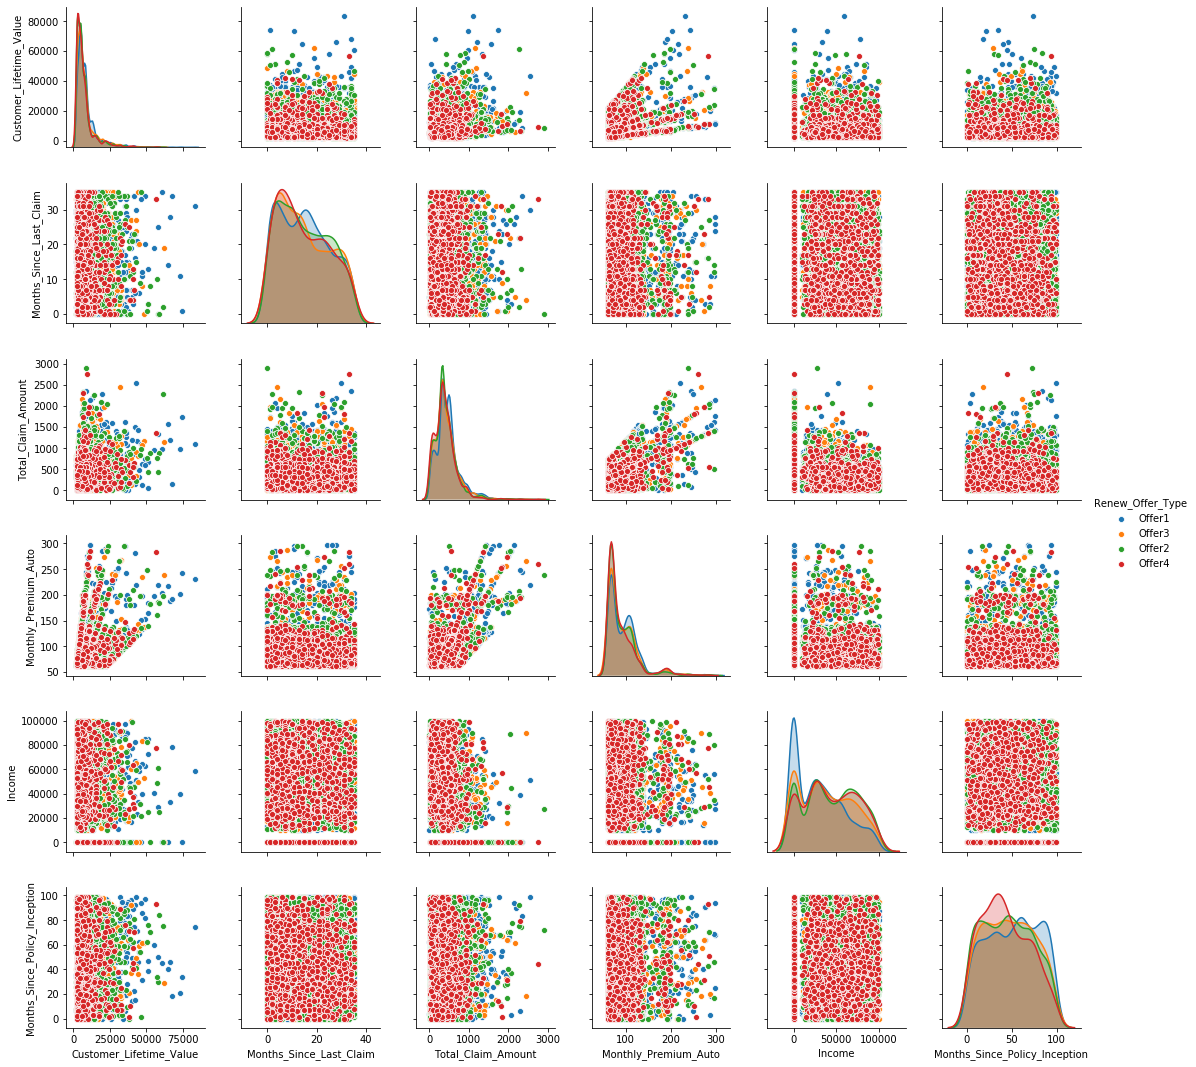

In [29]:
sns.pairplot(df, hue='Renew_Offer_Type', vars=num_var)

### 2.2.3 Sales_Channel

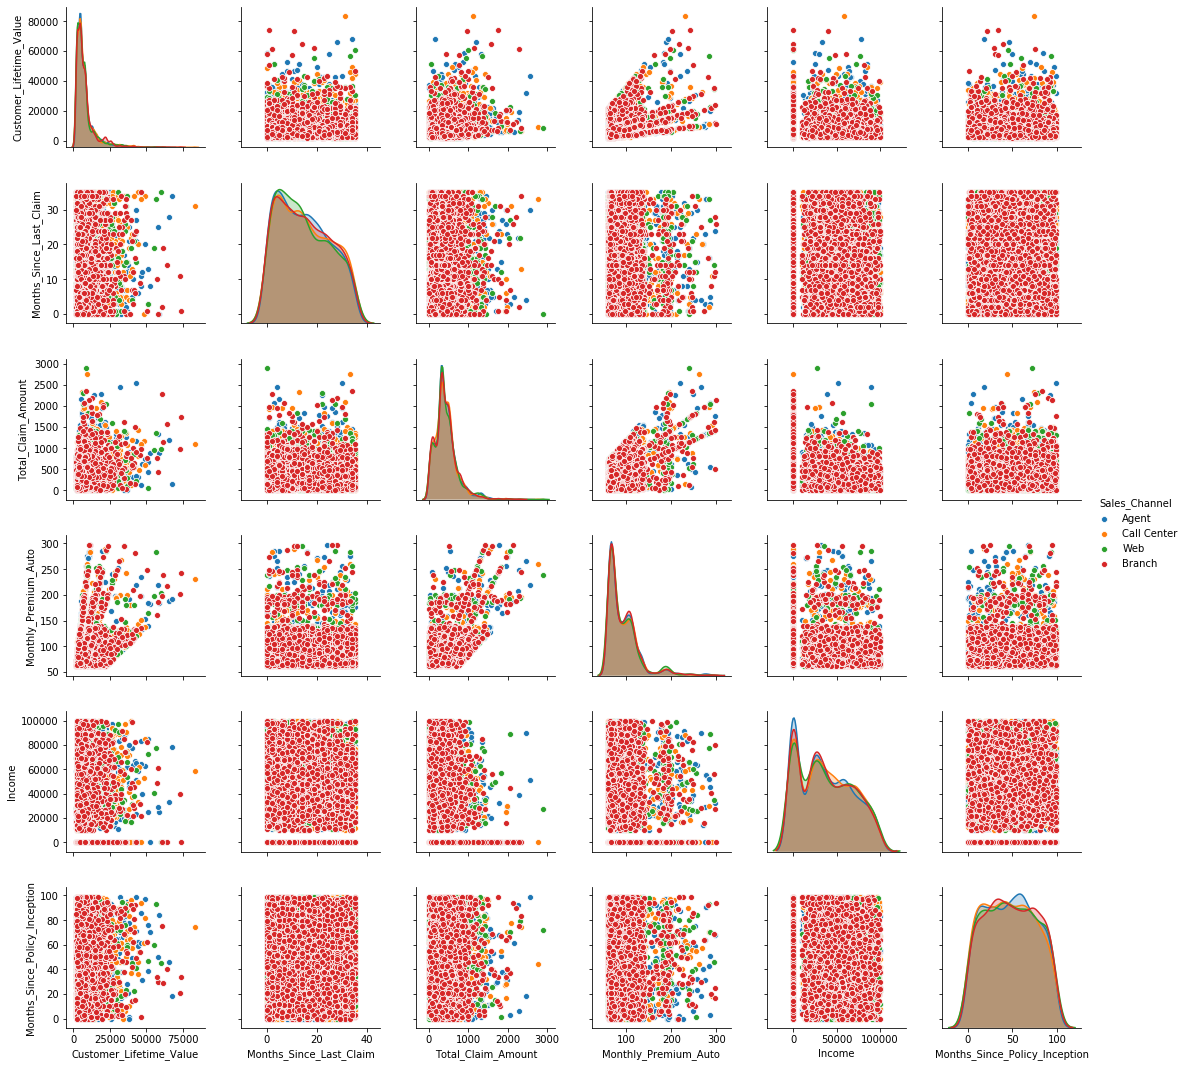

In [30]:
sns.pairplot(df, hue='Sales_Channel', vars=num_var)

### 2.2.4 Vehicle Size

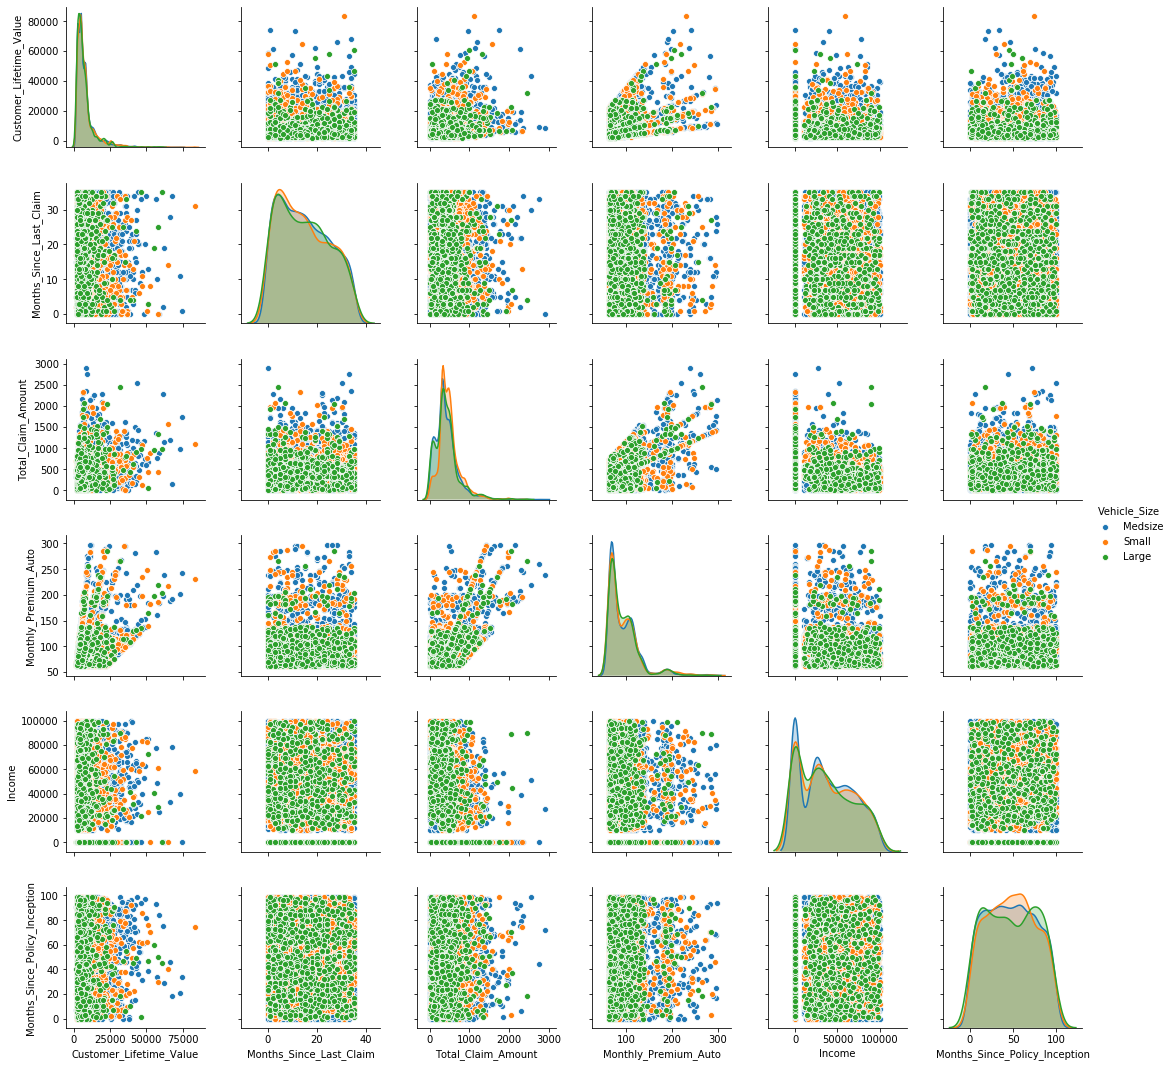

In [31]:
sns.pairplot(df, hue='Vehicle_Size', vars=num_var)

### 2.2.5 Analysis

It looks like Customer_Lifetime_Value is low when customers are:
- Branch
- Divorced 
- Offer 4
- Large Vehicle

We will use modelling to confirm this hypothesis...

## 2.3 KMeans Model All Numerical Data

We will build our model with KMeans on numerical data, then compare it to the scaled model


### 2.3.1 Find best params for KMeans

In [0]:
# Get X value
X = df[['Months_Since_Last_Claim',
 'Total_Claim_Amount',
 'Monthly_Premium_Auto',
 'Income',
 'Months_Since_Policy_Inception',
 'Customer_Lifetime_Value'
 ]]

In [0]:
# find best cluster size by plotting
scores = []
for i in range(2,12):
  # Build Model
  kmean_model = KMeans(random_state=42, n_clusters=i)
  kmean_model.fit(X)
  scores.append(kmean_model.inertia_)

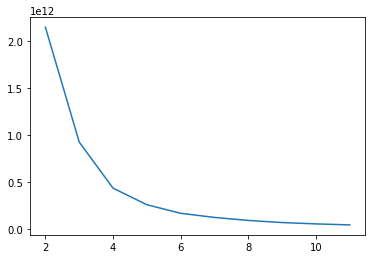

In [73]:
x_plot = range(2,12)
plt.plot(x_plot, scores)

The best n_cluster is 5

In [155]:
kmean_model = KMeans(random_state=42, n_clusters=5)
kmean_model.fit(X)
kmean_model.inertia_
print(f'The Silhouette score for Unscaled KMean is: {silhouette_score(X, kmean_model.labels_)}')

The Silhouette score for Unscaled KMean is: 0.5139436977213285


### 2.3.2 Plot Unscaled Data

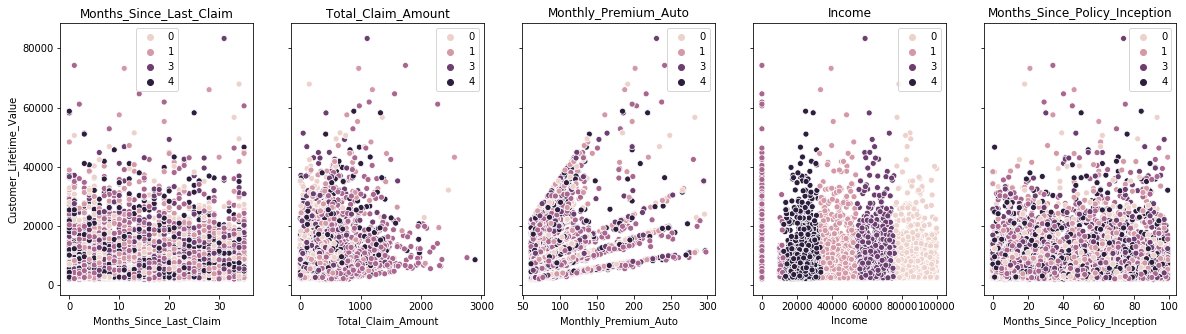

In [156]:
fig, axes = plt.subplots(1,5, sharey = True, figsize=(20,5))
for var, ax in zip(num_var, axes.flat):
  if var != 'Customer_Lifetime_Value':
    sns.scatterplot(
      x=var,
      y='Customer_Lifetime_Value',
      data=df,
      hue=kmean_model.labels_,
      ax = ax
    )
    ax.set_title(var)

### 2.3.3 Plot Scaled Data

In [157]:
# get X_scale
X_scale = StandardScaler().fit_transform(X)
X_scale[0]

array([ 1.67809933, -0.16963969, -0.70392465,  0.61282744, -1.54328695,
       -0.76280847])

In [159]:
# build model
kmean_model = KMeans(random_state=42, n_clusters=4)
kmean_model.fit(X_scale)
print(f'The Silhouette score for Scaled KMean is: {silhouette_score(X_scale, kmean_model.labels_)}')

The Silhouette score for Scaled KMean is: 0.1651796024263142


Text(0, 0.5, 'Customer_Lifetime_Value')

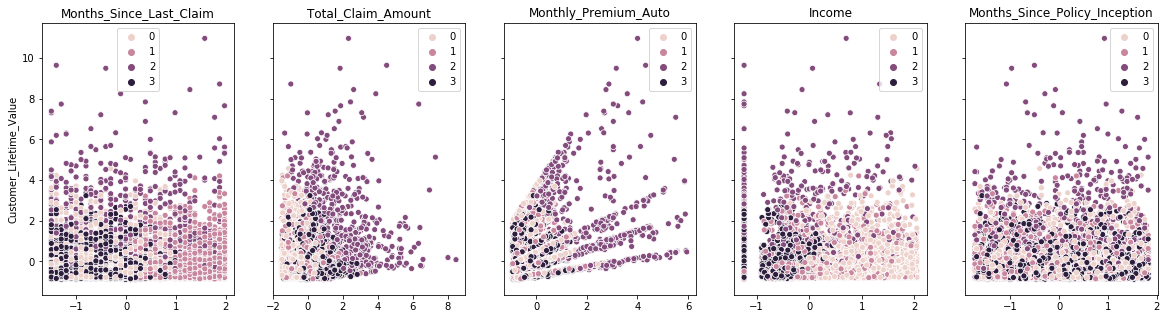

In [160]:
# plot
fig, axes = plt.subplots(1,5, sharey = True, figsize=(20,5))
for var, ax in zip(range(0,5), axes.flat):
  sns.scatterplot(
    x=X_scale[:,var],
    y=X_scale[:,5],
    hue=kmean_model.labels_,
    ax = ax
  )
  ax.set_title(num_var[var])

# we only want the legend on one axis ( HAX )
axes[0].set_ylabel('Customer_Lifetime_Value')

## 2.4 Gaussian Mixture Model (GMM ) All Numerical Data

### 2.4.1 Find best params (Unscaled)

In [161]:
# Confirm if we have the right columns
X.columns

Index(['Months_Since_Last_Claim', 'Total_Claim_Amount', 'Monthly_Premium_Auto',
       'Income', 'Months_Since_Policy_Inception', 'Customer_Lifetime_Value'],
      dtype='object')

In [97]:
# set variables
covariances = ['full', 'tied', 'diag', 'spherical']
clusters = np.arange(1,10)

# build arrays
params = [(cov, num) for cov, num in itertools.product(covariances, clusters)]

model_lst = [GaussianMixture(
    n_components=param[1],
    covariance_type=param[0],
    random_state=0
).fit(X) for param in params]

aic_lst = [m.aic(X) for m in model_lst]
bic_lst = [m.bic(X) for m in model_lst]

# create df to view data
score_df = pd.DataFrame(params, columns=['covariance type', 'n_components'])
score_df['aic'] = aic_lst
score_df['bic'] = bic_lst
score_df

covariance type  n_components            aic            bic
0             full             1  582744.954144  582887.349324
1             full             2  576766.351584  577058.261703
2             full             3  502866.725498  503308.150556
3             full             4  500961.185692  501552.125689
4             full             5  461425.569437  462166.024373
5             full             6  500450.470759  501340.440633
6             full             7  497315.587492  498355.072306
7             full             8  460731.218042  461920.217794
8             full             9  460638.358044  461976.872735
9             tied             1  582744.954144  582887.349324
10            tied             2  581305.428210  581490.541944
11            tied             3  580612.359282  580840.191570
12            tied             4  579139.081112  579409.631954
13            tied             5  578195.490276  578508.759672
14            tied             6  577184.898216  577540.886166
15            tied             7  576794.281664  577192.988167
16            tied             8  576182.635840  576624.060898
17            tied             9  575420.946389  575905.090000
18            diag             1  589429.220757  589500.418347
19            diag             2  580342.616078  580492.131017
20            diag             3  506784.020297  507011.852585
21            diag             4  505067.258534  505373.408171
22            diag             5  504783.110004  505167.576990
23            diag             6  500410.264729  500873.049063
24            diag             7  499731.011147  500272.112831
25            diag             8  499615.061954  500234.480986
26            diag             9  499154.971081  499852.707462
27       spherical             1  998883.250461  998925.969015
28       spherical             2  948258.427322  948350.984189
29       spherical             3  848390.522137  848532.917316
30       spherical             4  828649.792910  828842.026403
31       spherical             5  814062.583691  814304.655497
32       spherical             6  802260.472398  802552.382517
33       spherical             7  793840.728542  794182.476973
34       spherical             8  784751.727057  785143.313802
35       spherical             9  778070.149391  778511.574449

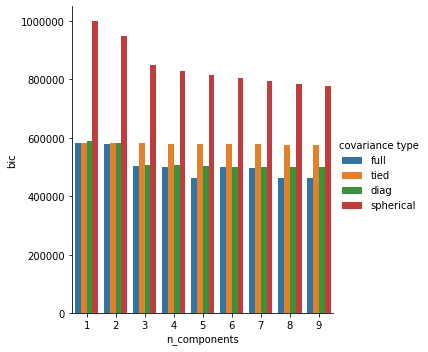

In [100]:
# Check which param is better with catplot
sns.catplot(
    x='n_components',
    y= 'bic',
    hue='covariance type',
    data=score_df,
    kind='bar'
)

In [99]:
# get index of lowest bic
score_df.bic.idxmin()

7

The best param for unscaled data is Covariance: Full and Cluster:8, but we will also try with 5, and 9 to not rule out any possibilities.

In [162]:
gmm_model = GaussianMixture(
    n_components=3,
    covariance_type='full',
    random_state=0
).fit(X)

print('N_components: 3, covariance_type: full')
print(f'Silhouette Score: {silhouette_score(X, gmm_model.predict(X))}')
print("\n")

gmm_model = GaussianMixture(
    n_components=4,
    covariance_type='full',
    random_state=0
).fit(X)

print('N_components: 4, covariance_type: full')
print(f'Silhouette Score: {silhouette_score(X, gmm_model.predict(X))}')
print("\n")


gmm_model = GaussianMixture(
    n_components=5,
    covariance_type='full',
    random_state=0
).fit(X)

print('N_components: 5, covariance_type: full')
print(f'Silhouette Score: {silhouette_score(X, gmm_model.predict(X))}')
print("\n")

gmm_model = GaussianMixture(
    n_components=8,
    covariance_type='full',
    random_state=0
).fit(X)

print('N_components: 8, covariance_type: full')
print(f'Silhouette Score: {silhouette_score(X, gmm_model.predict(X))}')
print("\n")

gmm_model = GaussianMixture(
    n_components=9,
    covariance_type='full',
    random_state=0
).fit(X)

print('N_components: 9, covariance_type: full')
print(f'Silhouette Score: {silhouette_score(X, gmm_model.predict(X))}')
print("\n")

N_components: 3, covariance_type: full
Silhouette Score: 0.24803133533735358


N_components: 4, covariance_type: full
Silhouette Score: 0.44560982665159665


N_components: 5, covariance_type: full
Silhouette Score: 0.15482987660464076


N_components: 8, covariance_type: full
Silhouette Score: 0.017254569428716095


N_components: 9, covariance_type: full
Silhouette Score: -0.08036078883405953




We will use 4 because it has the highest silhouette score

### 2.4.2 Plot unscaled data

In [0]:
# build final model
gmm_model = GaussianMixture(
    n_components=4,
    covariance_type='full',
    random_state=0
).fit(X)

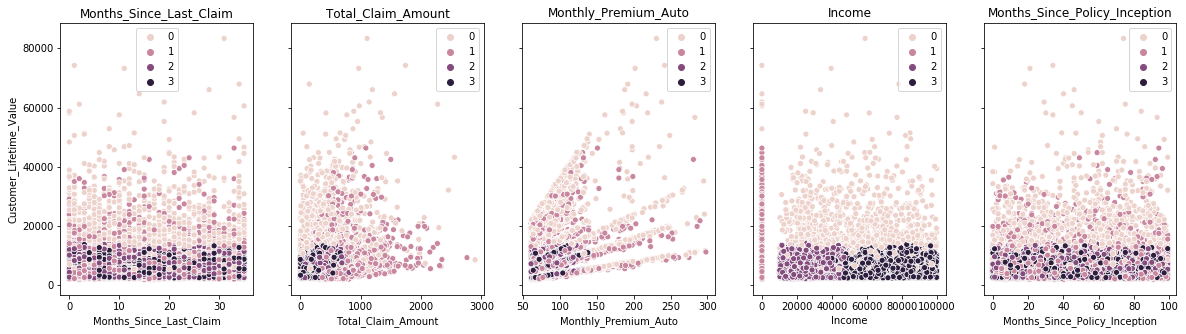

In [164]:
# plot gmm
fig, axes = plt.subplots(1,5, sharey = True, figsize=(20,5))
for var, ax in zip(num_var, axes.flat):
  if var != 'Customer_Lifetime_Value':
    sns.scatterplot(
      x=var,
      y='Customer_Lifetime_Value',
      data=df,
      hue=gmm_model.predict(X),
      ax = ax
    )
    ax.set_title(var)

### 2.4.3 Plot scaled data

In [165]:
# build Scaled Model
gmm_model = GaussianMixture(
    n_components=4,
    covariance_type='full',
    random_state=0
).fit(X_scale)

# Check score
print(f'Scaled Model has Silhouette Score: {silhouette_score(X_scale, gmm_model.predict(X_scale))}')

Scaled Model has Silhouette Score: 0.16435724551094022


Text(0, 0.5, 'Customer_Lifetime_Value')

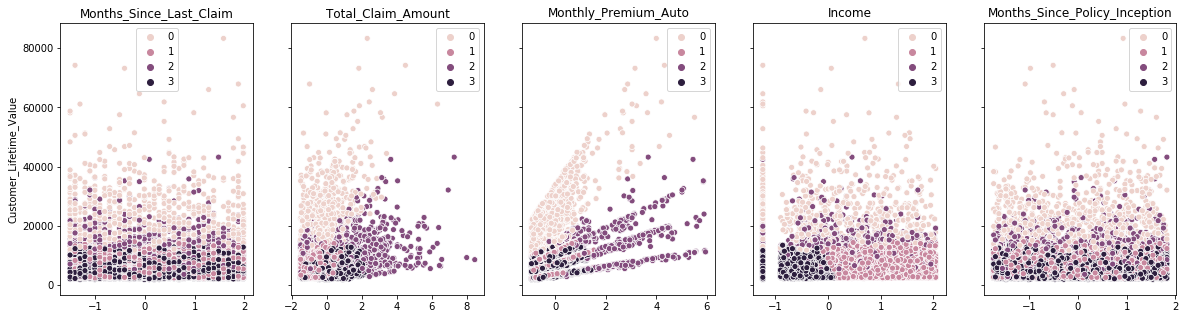

In [166]:
# Plot Data
fig, axes = plt.subplots(1,5, sharey = True, figsize=(20,5))
for var, ax in zip(range(0,5), axes.flat):
  sns.scatterplot(
    x=X_scale[:,var],
    y=df['Customer_Lifetime_Value'],
    hue=gmm_model.predict(X_scale),
    ax = ax
  )
  ax.set_title(num_var[var])
axes[0].set_ylabel('Customer_Lifetime_Value')

# 3 Conclusion

In Conclusion, even though KMeans have a better score, I chose to use the scaled data of GMM due its clustering pattern. When plotted against Customer_Lifetime_Value, we can easily tell the client who are the valuable clients (~[Branch, Divorced, Offer 4, Large Vehicle])

# 4 Revisited

The following code is written after my presentation and watching others present the same data.

I realized I might have tried to *bite off more than you can chew* and should have kept my presentation simple and only used 2 variables when building the model. 

This would've been simpler for the audience to follow ( especially when the target audience is a marketing team )

## 4.1 Parameters

We will constraint our XY numerical data to just 2 points:
- Customer_Lifetime_Value
- Income

In [0]:
# variables
X = df[['Customer_Lifetime_Value', 'Income']]
X_scale = StandardScaler().fit_transform(X)

## 4.2 KMeans Modelling

We will first explore KMEans and get the optimal cluster by plotting the inertia onto a line graph and finding the **elbow**.

Then, build a model with both scaled and unscaled data and use silhouette score to determine which model is best.

### 4.2.1 Get Params

In [0]:
# build model
clusters = np.arange(1, 10)
kmean_models = [KMeans(n_clusters=n).fit(X) for n in clusters]
inertias = [model.inertia_ for model in kmean_models]

Text(0.5, 1.0, 'The elbow is at 4')

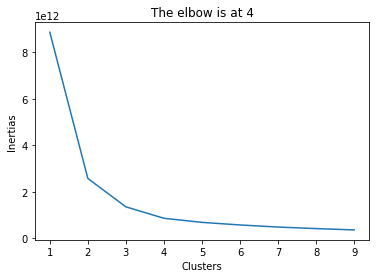

In [24]:
# plot
plt.plot(clusters, inertias)
plt.xlabel('Clusters')
plt.ylabel('Inertias')
plt.title('The elbow is at 4')

We will use 4 as our preferred parametr for KMeans

### 4.2.2 Unscaled Data ( Silhouette Score: 0.54)

In [71]:
# build model
kmean_model = KMeans(n_clusters=4).fit(X)

# get score
silhouette_score(X, kmean_model.labels_)

0.5447794797168567

#### 4.2.2.1 plot

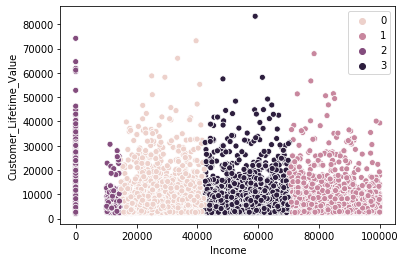

In [72]:
sns.scatterplot(
    df['Income'],
    df['Customer_Lifetime_Value'],
    hue = kmean_model.labels_
)

### 4.2.3 Scaled Data ( Silhouette Score: 0.41)

In [26]:
# build model
kmean_model = KMeans(n_clusters=4).fit(X_scale)

# get score
silhouette_score(X_scale, kmean_model.labels_)

0.40866062612835585

## 4.3 DBSCAN ( Score: 0.84)

### 4.3.1 Finding eps?

With Default settings, we got a negative score..

In [32]:
# build model
eps = np.arange(0.1, 1, 0.1)
db_model = [DBSCAN(eps=e).fit(X) for e in eps]
score = [silhouette_score(X,model.labels_) for model in db_model]
score

[-0.6795878052617301,
 -0.6795878052617301,
 -0.6795878052617301,
 -0.6795878052617301,
 -0.6795878052617301,
 -0.6795878052617301,
 -0.6795878052617301,
 -0.6795878052617301,
 -0.6795878052617301]

In [33]:
# build model
eps = np.arange(1, 10, 1)
db_model = [DBSCAN(eps=e).fit(X) for e in eps]
score = [silhouette_score(X,model.labels_) for model in db_model]
score

[-0.6685740396343112,
 -0.6251836915685848,
 -0.5784169814209794,
 -0.5454237841012132,
 -0.5146126878112044,
 -0.48596427748202053,
 -0.4730646143452326,
 -0.46259771204318867,
 -0.44988162919046315]

In [34]:
# build model
eps = np.arange(10, 100, 10)
db_model = [DBSCAN(eps=e).fit(X) for e in eps]
score = [silhouette_score(X,model.labels_) for model in db_model]
score

[-0.44245375486026256,
 -0.4339114911159525,
 -0.49253667522774863,
 -0.45224271518177594,
 -0.4964680498738675,
 -0.3904118660990073,
 -0.38504560523167597,
 -0.37602598733217774,
 -0.36047635736161937]

### 4.3.2 Scaled Data?

We got our best score here, but upon further analysis (plotting) we see that the labels SUCK

In [44]:
# Seeing that our silhouette score is negative, we will jump straight into scaled data
eps = np.arange(1, 10, 1)
db_model = [DBSCAN(eps=e).fit(X_scale) for e in eps]
score = []
for model in db_model:
  try:
    score.append(
        silhouette_score(X_scale, model.labels_)
    )
  except:
    pass 
score


[0.8173558595206807]

In [45]:
# Seeing that our silhouette score is negative, we will jump straight into scaled data
eps = np.arange(0.1, 1, 0.1)
db_model = [DBSCAN(eps=e).fit(X_scale) for e in eps]
score = []
for model in db_model:
  try:
    score.append(
        silhouette_score(X_scale, model.labels_)
    )
  except:
    pass 
score


[0.1848054218011152,
 0.29883913384192157,
 0.3097108098933962,
 0.7520693606739359,
 0.722855263400666,
 0.7228744825243401,
 0.7866534987100566,
 0.7586640754188267,
 0.8173558595206807]

In [37]:
# Seeing that our silhouette score is negative, we will jump straight into scaled data
eps = np.arange(1, 3, 0.2)
db_model = [DBSCAN(eps=e).fit(X_scale) for e in eps]
score = []
for model in db_model:
  try:
    score.append(
        silhouette_score(X_scale, model.labels_)
    )
  except:
    pass 
score


[0.8173558595206807, 0.823697857571857, 0.8244835449550918, 0.8422232940677927]

In [39]:
best_model = db_model[3]
best_model.get_params

<bound method BaseEstimator.get_params of DBSCAN(algorithm='auto', eps=1.5999999999999999, leaf_size=30,
       metric='euclidean', metric_params=None, min_samples=5, n_jobs=None,
       p=None)>

It looks like DBSCAN performs poorly on unscaled data, and the best eps is ~1.6 with a silhouette score of 8.4

### 4.3.3 Plot best model

Text(0.5, 1.0, 'DBScan with score 0.84')

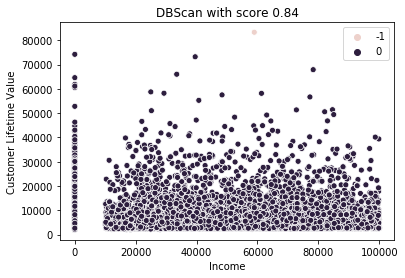

In [41]:
sns.scatterplot(
    df['Income'],
    df['Customer_Lifetime_Value'],
    hue = best_model.labels_
)

plt.xlabel('Income')
plt.ylabel('Customer Lifetime Value')
plt.title('DBScan with score 0.84')

## 4.4 Agglomerative Clustering (Score: 0.8)

### 4.4.1 params

In [0]:
# params
linkages = ["ward", "complete", "average", "single"]
clusters = np.arange(2,10)

# build param array
params = [(cov, num) for cov, num in itertools.product(linkages, clusters)]

### 4.4.2 Unscale (Optimal Score: 0.53)

In [0]:
# build model
ac_model = [AgglomerativeClustering(linkage=param[0], n_clusters=param[1]).fit(X) for param in params]

In [0]:
# We separate these 2 cells and add a try here because we somehow got an error, and I'm too lazy to figure out why..

"""
  The code below gave us an error
  
  scores = [silhouette_score(X,model.labels_) for model in ac_model]
  scores
"""

scores = {}
for model in ac_model:
  try:
    score = silhouette_score(X,model.labels_)
    scores[score] = model
  except:
    pass

In [55]:
print(f'we got {len(scores)} scores')

we got 32 scores


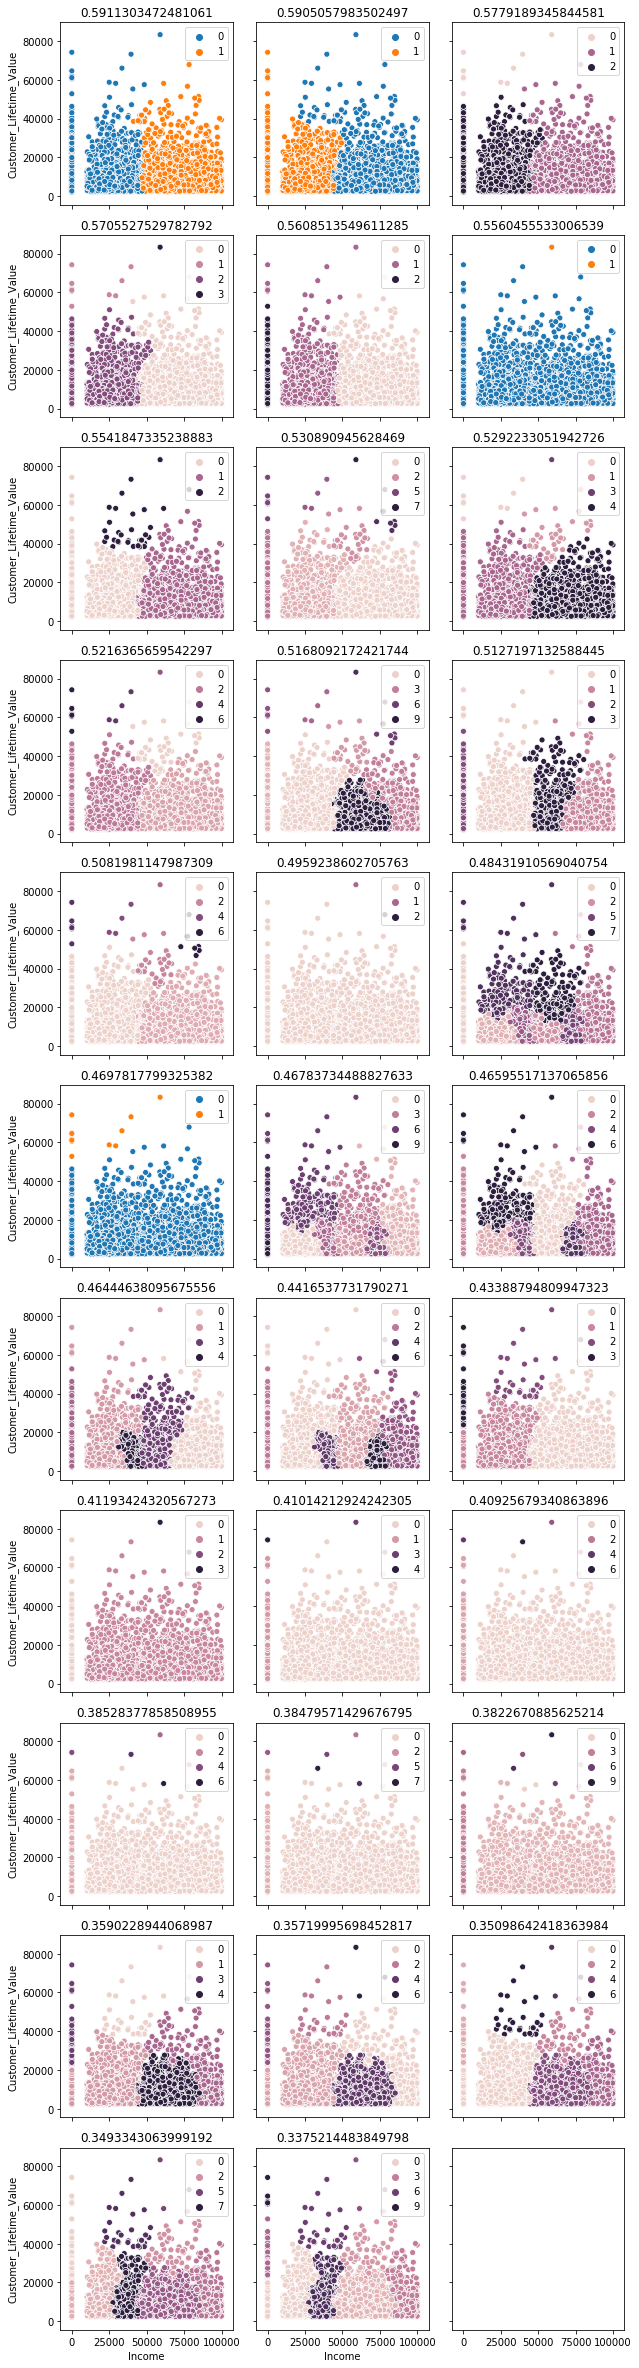

In [58]:
# get params of best score and plot it..
fig, axes = plt.subplots(11,3, sharex=True, sharey=True, figsize=(9,33))

for score, ax in zip(sorted(scores.keys(), reverse=True), axes.flat):
  model = scores[score]
  sns.scatterplot(
      df['Income'],
      df['Customer_Lifetime_Value'],
      hue = model.labels_,
      ax=ax
  )
  ax.set_title(score:.2f)

fig.tight_layout()


### 4.4.3 Scaled (Optimal Score: 0.55)

In [0]:
# scaled X
ac_model = [AgglomerativeClustering(linkage=param[0], n_clusters=param[1]).fit(X_scale) for param in params]

In [0]:
# get scores
scores = {}
for model in ac_model:
  try:
    score = silhouette_score(X_scale,model.labels_)
    scores[score] = model
  except:
    pass

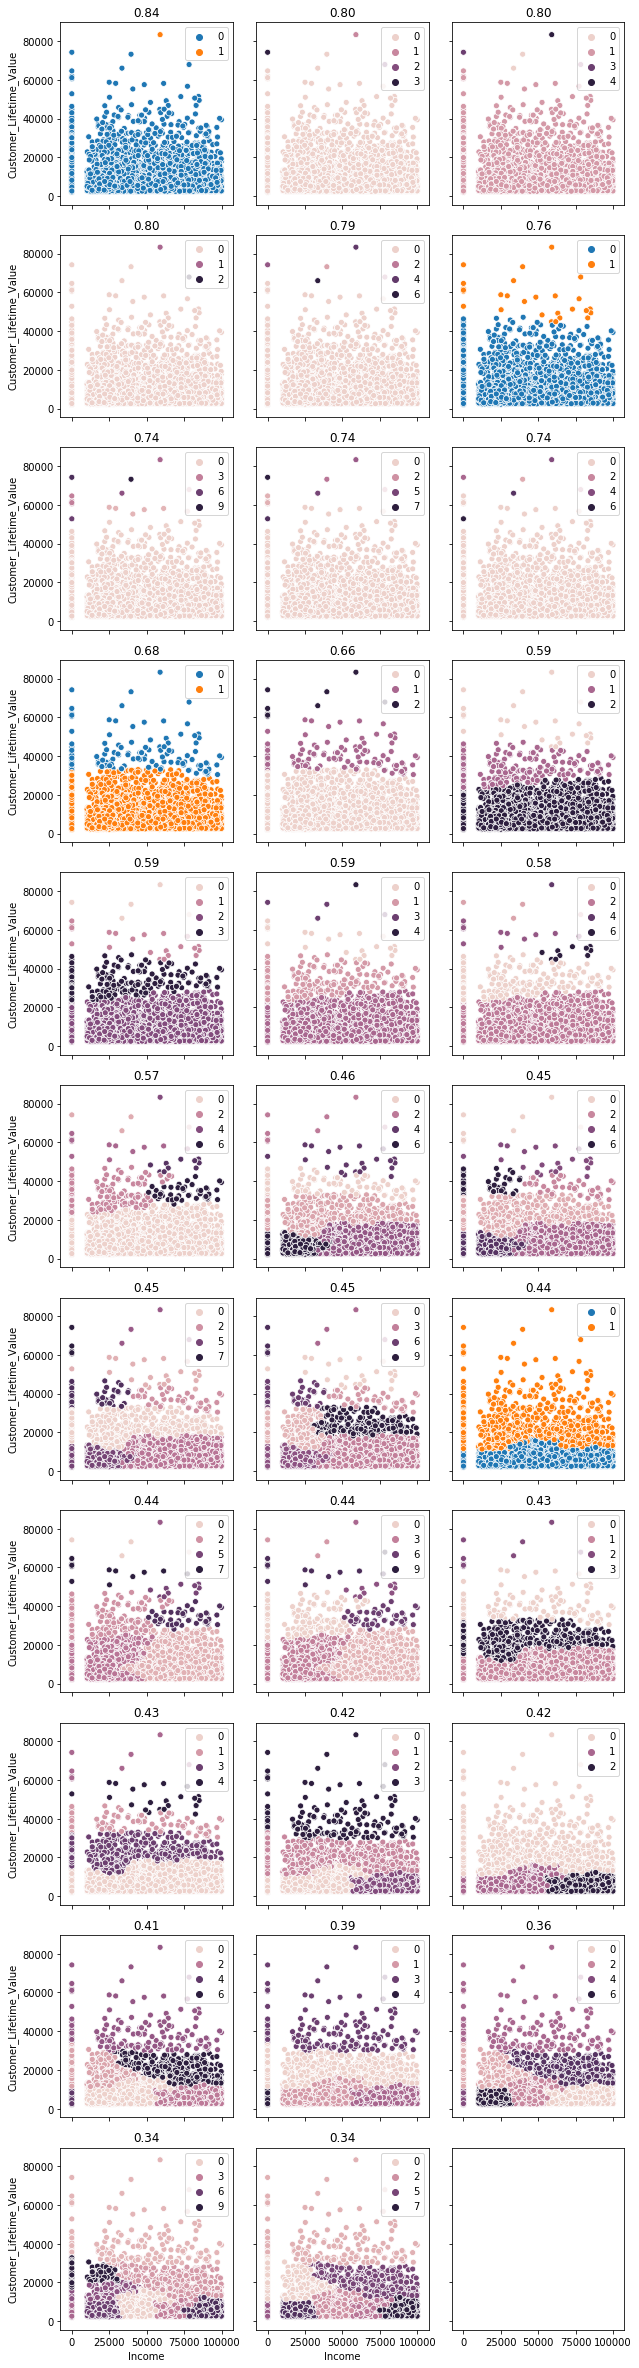

In [68]:
# get params of best score and plot it..
fig, axes = plt.subplots(11,3, sharex=True, sharey=True, figsize=(9,33))

for score, ax in zip(sorted(scores.keys(), reverse=True), axes.flat):
  model = scores[score]
  sns.scatterplot(
      df['Income'],
      df['Customer_Lifetime_Value'],
      hue = model.labels_,
      ax=ax
  )
  ax.set_title(f'{score:.2f}')

fig.tight_layout()


## 4.5 GMM

Find the optimal parameters (Covariances and Clusters) by comparing BIC ( Lower is better)

- Bayesian information criterion (BIC) is a criterion for model selection among a finite set of models
- it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting
- BIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model

### 4.5.1 Unscaled Data (Score: 0.35)

In [0]:
# set variables
covariances = ['full', 'tied', 'diag', 'spherical']
clusters = np.arange(1,10)

# build arrays
params = [(cov, num) for cov, num in itertools.product(covariances, clusters)]

model_lst = [GaussianMixture(
    n_components=param[1],
    covariance_type=param[0]
).fit(X) for param in params]

aic_lst = [m.aic(X) for m in model_lst]
bic_lst = [m.bic(X) for m in model_lst]

# create df to view data
score_df = pd.DataFrame(params, columns=['covariance type', 'n_components'])
score_df['aic'] = aic_lst
score_df['bic'] = bic_lst

In [18]:
# lowest bic
print(f'The optimal gmm is at {score_df.bic.idxmin()} \n with score: \n')

# get params
score_df.iloc[8]

The optimal gmm is at 26 
 with score: 



covariance type      full
n_components            9
aic                318572
bic                318949
Name: 8, dtype: object

In [69]:
# get silhouettet score of new model
model = GaussianMixture(
    n_components=9,
    covariance_type='full'
).fit(X)
print(f'Silhouette score of unscaled data: {silhouette_score(X, model.predict(X))}')

Silhouette score of unscaled data: 0.34895789495136564


##### 4.5.1.1 Plot (we are using this one for the presentation)

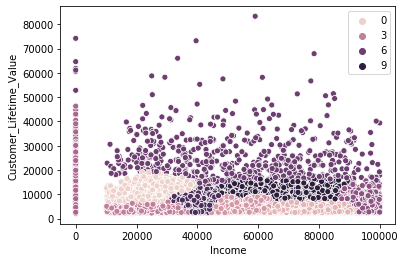

In [70]:
sns.scatterplot(
      df['Income'],
      df['Customer_Lifetime_Value'],
      hue = model.predict(X)
  )

### 4.5.2 Scaled Data (Score: 0.31)

In [0]:
# fit models
models = [GaussianMixture(
    n_components=param[1],
    covariance_type=param[0]
).fit(X_scale) for param in params]

aic_lst = [model.aic(X_scale) for model in models]
bic_lst = [model.bic(X_scale) for model in models]

# create df to view data
score_df = pd.DataFrame(params, columns=['covariance type', 'n_components'])
score_df['aic'] = aic_lst
score_df['bic'] = bic_lst

In [15]:
# lowest bic
print(f'The optimal gmm is at {score_df.bic.idxmin()} \n with score: \n')

# get params
score_df.iloc[score_df.bic.idxmin()]

The optimal gmm is at 26 
 with score: 



covariance type       diag
n_components             9
aic                14499.2
bic                14812.5
Name: 26, dtype: object

In [16]:
# get scores
gmm = GaussianMixture(
    n_components=9,
    covariance_type='diag'
).fit(X_scale)
print(f' Silhouette score for scaled data: {silhouette_score(X_scale, gmm.predict(X_scale))}')

 Silhouette score for scaled data: 0.3092244428419344


# 5 Further Analysis

We did not go with DBSCAN (best score) because upon further analysis, it grouped all datapoints to one cluster.

Ideally, we want to know who the valuable customers are so the company can retain them. We would also like to know the features of the invaluable customers so we can plan ways to move them into the valuable cluster.

We will provide the baseline model, and show how much of an improvement our tuned model has ( primarily to show employers that they didn't waste their money hiriing us and [fuck you, pay me](https://www.youtube.com/watch?v=oEa6PdOG2ts))

## 5.1 Baseline model (reiterated)

The baseline model clustered everything into 1 group, which gives us nonsense data

In [0]:
# get silhouettet score of new model
model = GaussianMixture().fit(X)

In [78]:
from collections import Counter
Counter(model.predict(X))

Counter({0: 9134})

## 5.2 Improved Model (infinite improvement)

due to not using random state, the scores have differed from the top 😛

In [79]:
# get silhouettet score of new model
model = GaussianMixture(
    n_components=9,
    covariance_type='full'
).fit(X)

print(f'Silhouette score of unscaled data: {silhouette_score(X, model.predict(X))}')

Silhouette score of unscaled data: 0.3465977212893308


### 5.2.1 plot model

Text(0.5, 1.0, 'Silhouette Score: 0.35')

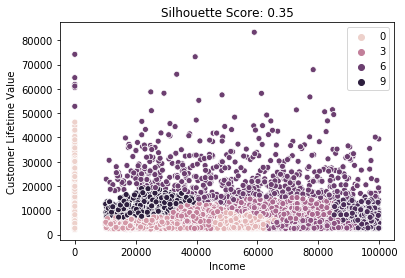

In [83]:
sns.scatterplot(
    df['Income'],
    df['Customer_Lifetime_Value'],
    hue = model.predict(X)
)

plt.xlabel('Income')
plt.ylabel('Customer Lifetime Value')
plt.title(f'Silhouette Score: 0.35')

we want to filter out the cluster that tells us who the valuable cusotmers are

In [0]:
hue = model.predict(X)

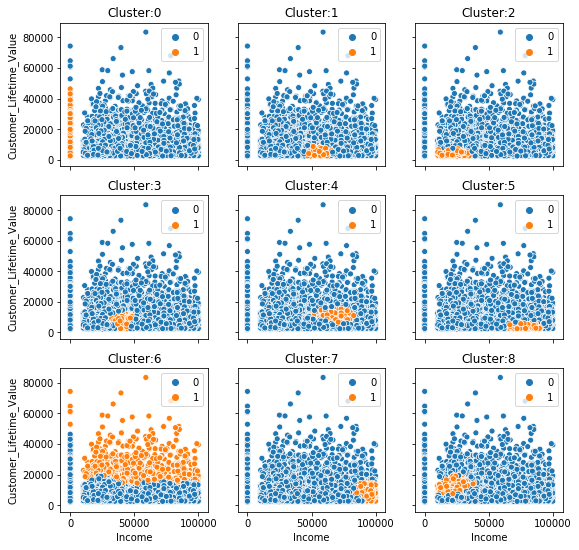

In [90]:
fig, axes = plt.subplots(3,3,sharex=True, sharey=True, figsize=(9,9))
for i, ax in zip(range(0,9), axes.flat):
  _hue = list(map(lambda x: 1 if x==i else 0, hue))
  sns.scatterplot(
    df['Income'],
    df['Customer_Lifetime_Value'],
    hue = _hue,
    ax=ax
  )
  ax.set_title(f'Cluster:{i}')
  

We want to group cluster 6 and show the client that this cluster contains the most valuable peopleu

Text(0.5, 1.0, 'Most Valuable Customers')

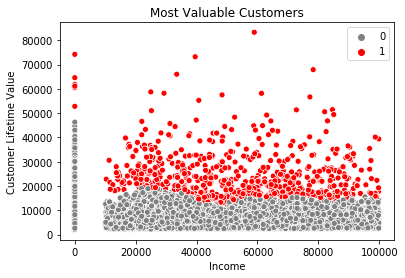

In [103]:
_hue = list(map(lambda x: 1 if x==6 else 0, hue))

sns.scatterplot(
    df['Income'],
    df['Customer_Lifetime_Value'],
    hue =_hue,
    palette=['Grey', 'Red']
)
plt.xlabel('Income')
plt.ylabel('Customer Lifetime Value')
plt.title('Most Valuable Customers')

## 5.3 Who are the most valuable customers?

We will add another column to df, and do value counts to find out the characteristics of the most valuable customers

In [118]:
# add column
df['MVP'] = hue

# value counts
for i in range(0,9):
  _df = df[df.MVP == i]
  print(i)
  for column in cat_var:
    if column != 'Customer':
      print(f'{column} - {_df[column].value_counts(normalize=True)}')

0
MVP - 0    1.0
Name: MVP, dtype: float64
Renew_Offer_Type - Offer1    0.530506
Offer2    0.233232
Offer3    0.154046
Offer4    0.082215
Name: Renew_Offer_Type, dtype: float64
Marital_Status - Single      0.576807
Married     0.334055
Divorced    0.089139
Name: Marital_Status, dtype: float64
Vehicle_Size - Medsize    0.689745
Small      0.198183
Large      0.112073
Name: Vehicle_Size, dtype: float64
Sales_Channel - Agent          0.390740
Branch         0.276504
Call Center    0.188663
Web            0.144093
Name: Sales_Channel, dtype: float64
1
MVP - 1    1.0
Name: MVP, dtype: float64
Renew_Offer_Type - Offer1    0.379562
Offer2    0.350365
Offer3    0.154327
Offer4    0.115746
Name: Renew_Offer_Type, dtype: float64
Marital_Status - Married     0.675704
Single      0.188738
Divorced    0.135558
Name: Marital_Status, dtype: float64
Vehicle_Size - Medsize    0.721585
Small      0.185610
Large      0.092805
Name: Vehicle_Size, dtype: float64
Sales_Channel - Agent          0.397289
Bran

Customer       State  ...  Vehicle_Size MVP
0     BU79786  Washington  ...       Medsize   1
6     XZ87318      Oregon  ...       Medsize   1
18    WC83389      Oregon  ...       Medsize   1
20    ZK25313      Oregon  ...       Medsize   1
33    AO98601  Washington  ...         Small   1
...       ...         ...  ...           ...  ..
9104  LM97847  California  ...       Medsize   1
9113  HO82823  California  ...       Medsize   1
9117  QR91631  California  ...       Medsize   1
9119  YX35990  California  ...         Small   1
9128  YM19146  California  ...         Large   1

[959 rows x 25 columns]